# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:
from utils.data_import import get_sp100

# Options
FIRST_DATE  = "2020-01-01"
LAST_DATE   = "2025-01-01"
N_PROCESSES = 10
MKT_INDEX   = "^SP100"

df_prices = get_sp100(FIRST_DATE,LAST_DATE)

df_prices.head()

Fetching SP100 components
	-> got 101 tickers



C:\Users\jpsan\Documents\GitHub\bootcamp-ds-4ed\utils\data_import.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=FIRST_DATE, end=LAST_DATE)["Close"]
[*********************100%***********************]  102 of 102 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


,ticker,Adj Close
Date,,
2020-01-02,AAPL,72.538513
2020-01-03,AAPL,71.833298
2020-01-06,AAPL,72.405670
2020-01-07,AAPL,72.065163
2020-01-08,AAPL,73.224434


## Cleaning and Splitting the Data

In [2]:
from utils.data_clean import clean_data

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.75   # defines the size of train dataset (in %)

df_ret, df_train, df_test  = clean_data(
    df_prices, 
    mkt_symbol=MKT_INDEX,
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128316 entries, 2020-01-02 to 2024-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ticker     128316 non-null  object 
 1   Adj Close  126870 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.9+ MB
None
Size original: (128316, 2)
Size reduced: (128316, 2)


## Unconstrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   & w_i \geq 0 \\
\end{array}
$



$
\begin{array}{lll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [3]:
import gurobipy as gp
import pandas as pd
import numpy as np
from random import sample, seed

seed(20220209) # reproducibility

mkt_index = "^SP100"
n_assets = 20

# data from main notebook
r_it = df_train

# Gets the market index data
r_mkt = r_it[mkt_index]

# Removes market index form r_it, the "training" data, used it in the otimization problem
r_it = r_it.drop(mkt_index, axis = 1)

tickers = list(r_it.columns)

# Escolhe n ativos aleatórios para testar o modelo
sampled_tickers = sample(tickers, n_assets)
r_it = r_it[sampled_tickers]

print(r_it.head())

ticker           RTX       ABT       AMD        MS        MA      ISRG  \
Date                                                                     
2020-10-01 -0.001390 -0.001746  0.035004 -0.022544  0.015377  0.001381   
2020-10-02  0.032719 -0.019698 -0.036059  0.015024 -0.013222 -0.020042   
2020-10-05  0.002865  0.019343  0.053178  0.013133  0.013045  0.016401   
2020-10-06 -0.017812 -0.021278 -0.019385 -0.017696 -0.016955 -0.012265   
2020-10-07  0.021215  0.014024  0.026160  0.020319  0.019174  0.030414   

ticker          SBUX       HON       LLY      MDLZ       PFE       SPG  \
Date                                                                     
2020-10-01  0.009544 -0.005650 -0.025199  0.008007 -0.008992  0.028602   
2020-10-02 -0.001960  0.011791  0.006376 -0.018132  0.000275  0.025101   
2020-10-05  0.021948  0.018779  0.009779  0.003869  0.010170  0.008211   
2020-10-06 -0.016503 -0.010847 -0.017050 -0.017344 -0.015782  0.017743   
2020-10-07  0.016549  0.027923  0.033

# Setup opt problem and solve

In [7]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')


# PARAMETERS 
# w_i: the i_th stock gets a weight w_i within the range 0 to 1
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# CONSTRAINTS
# sum(w_i) = 1: portfolio budget constrain (long only)
# 100% of the budget invested
m.addConstr(w.sum() == 1, 'port_budget')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function, minimize the sum of squared tracking errors between portfolio and market returns
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.optimize()

w_hat  = [i.X for i in m.getVars()]

print(f"Solution:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")

Restricted license - for non-production use only - expires 2026-11-23
Solution:
SBUX:	 4.80%
ABT:	 3.79%
AMD:	 4.60%
MS:	 3.13%
MA:	 6.10%
ISRG:	 3.07%
SCHW:	 0.43%
HON:	 4.92%
LLY:	 4.31%
MDLZ:	 5.01%
PG:	 7.56%
T:	 3.23%
UNH:	 5.63%
GE:	 0.59%
MO:	 3.35%
AVGO:	 9.55%
BLK:	 6.34%
INTC:	 2.28%
GOOGL:	 17.76%
BAC:	 3.55%

checking constraints:
sum(w) = 0.9999999999999459


In [8]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = df_test

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()

: 

## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [8]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 
max_assets = 10
# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)
# [NEW] z_i: the i_th stock gets a binary z_i
z = pd.Series(m.addVars(sampled_tickers,
                        vtype = gp.GRB.BINARY),
                index=sampled_tickers)

# CONSTRAINTS
# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')
# [NEW]  w_i <= z_i: restrictions of values of w_i so take it chose particular tickers
for i_ticker in sampled_tickers:
    m.addConstr(w[i_ticker] <= z[i_ticker], 
                f'dummy_restriction_{i_ticker}')
# [NEW] sum(z_i) <= max_assets: number of assets constraint
m.addConstr(z.sum() <= max_assets, 'max_assets_restriction')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function, minimize the sum of squared tracking errors between portfolio and market returns
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.setParam('TimeLimit', 60*5) # in secs
#m.setParam('MIPGap', 0.05) # in secs
m.optimize()

params = [i.X for i in m.getVars()]

n_assets = len(sampled_tickers)
w_hat = params[0:n_assets]
z_hat = params[n_assets:]
MIPGap = m.getAttr('MIPGap')
status = m.getAttr("Status")

print(f"Solution for w:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")
print(f"sum(z) = {np.sum(z_hat)}")
print(f"w <= z = {w_hat <= z_hat}")
print(f"MIPGap={MIPGap}")
print(f"Status={status}")

Solution for w:
RTX:	 0.00%
ABT:	 8.21%
AMD:	 4.86%
MS:	 0.00%
MA:	 9.20%
ISRG:	 0.00%
SBUX:	 0.00%
HON:	 9.29%
LLY:	 6.81%
MDLZ:	 16.12%
PFE:	 0.00%
SPG:	 0.00%
UBER:	 0.00%
GE:	 0.00%
MO:	 0.00%
AVGO:	 10.80%
BLK:	 8.64%
INTC:	 0.00%
GOOGL:	 18.60%
BAC:	 7.49%

checking constraints:
sum(w) = 1.0
sum(z) = 10.0
w <= z = True
MIPGap=0.0
Status=2


Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT',
       'AMZN',
       ...
       'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM', '^SP100'],
      dtype='object', name='ticker', length=101)
['RTX', 'ABT', 'AMD', 'MS', 'MA', 'ISRG', 'SBUX', 'HON', 'LLY', 'MDLZ', 'PFE', 'SPG', 'UBER', 'GE', 'MO', 'AVGO', 'BLK', 'INTC', 'GOOGL', 'BAC']


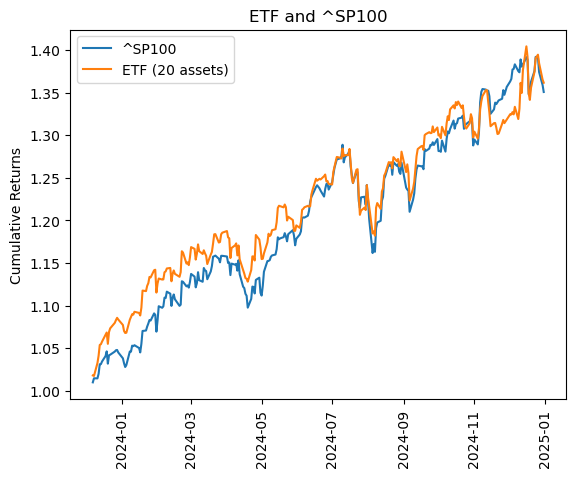

In [7]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = df_test

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()